In [45]:
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.updaters import Tally, cut_edges

from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import propose_random_flip
from gerrychain.proposals import recom
from gerrychain.accept import always_accept

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from functools import partial

import networkx

import maup
import geopandas

This notebook contains tutorial on how to use GerryChain package from https://gerrychain.readthedocs.io/en/latest/user/install.html

# 1: Getting started with GerryChain

A guid to how to start generating ensembles with GerryChain, using MGGG’s Pennsylvania shapefile

## Creating the initial partition

In order to run a Markov chain, we need an adjacency Graph of our VTD geometries and Partition of our adjacency graph into districts. This Partition will be the initial state of our Markov chain.

In [3]:
# creates a Graph of the precincts
# copies all of the data columns from
# the shapefile’s attribute table to the graph object as node attributes

# Pennsylvania Election Shapefile
graph = Graph.from_json("./PA_VTDs.json")

In [4]:
# configure an Election object representing the 2012 Senate election
# using the USS12D and USS12R vote total columns from our shapefil

# ("SEN12") is a name for the election
# and the second argument is a dictionary matching 
# political parties to their vote total columns in shapefile

# This will let us compute hypothetical election results 
# for each districting plan in the ensemble
election = Election("SEN12", {"Dem": "USS12D", "Rep": "USS12R"})

In [6]:
# create a Partition of the graph. 
# This will be the starting point for our Markov chain

# assignment="CD_2011" to tell the Partition to assign nodes 
# by their "CD_2011" attribute that we copied from the shapefile
# This attributes holds the assignments of precincts to 
# congressional districts from the 2010 redistricting cycle

# an updater named "population" that computes the total population
# of each district in the partition, 
# based on the "TOTPOP" node attribute from shapefile

# “SEN12” updater that will output the election results 
# for the election that set up
initial_partition = Partition(
    graph,
    assignment="CD_2011",
    updaters={
        "cut_edges": cut_edges,
        "population": Tally("TOTPOP", alias="population"),
        "SEN12": election
    }
)

In [9]:
# see the total population in each of congressional districts
distict_population = sorted(initial_partition['population'].items(),
                            key=lambda x: x[0])
for district, pop in distict_population:
    print("District {}: {}".format(district, pop))

District 1: 705588
District 2: 705689
District 3: 705317
District 4: 705669
District 5: 706258
District 6: 705782
District 7: 706391
District 8: 705689
District 9: 705679
District 10: 705327
District 11: 705883
District 12: 705698
District 13: 705028
District 14: 705526
District 15: 705549
District 16: 705629
District 17: 705830
District 18: 705847


## Running a chain

Now that we have our initial partition, we can configure and run a Markov chain. Let’s configure a short Markov chain to make sure everything works properly.

To configure a chain, we need to specify five objects.

* proposal:	

    A function that takes the current state and returns new district assignments (“flips”) for one or more nodes. This comes in the form of a dictionary mapping one or more node IDs to their new district IDs. Here we’ve used the propose_random_flip proposal, which proposes that a random node on the boundary of one district be flipped into the neighboring district.
    

* constraints:	
    
    A list of binary constraints (functions that take a partition and return True or False) that together define which districting plans. are valid. Here we’ve used just a single constraint, single_flip_contiguous, which checks that each district in the plan is contiguous. This particular constraint is optimized for the single-flip proposal function we are using (hence the name). We could add more constraints to require that districts have nearly-equal population, to impose a bound on the compactness of the districts according to some score, or to prevent districts from splitting more counties than the original plan.


* accept:	

    A function that takes a valid proposed state and returns True or False to signal whether the random walk should indeed move to the proposed state. always_accept always accepts valid proposed states. If you want to implement Metropolis-Hastings or any other more sophisticated acceptance criterion, you can specify your own custom acceptance function here.


* initial_state:	

    The first state of the random walk.
    

* total_steps:	

    The total number of steps to take. Invalid proposals are not counted toward this total, but rejected (by accept) valid states are.

In [11]:
# configures a Markov chain called chain, but does not run it yet
chain = MarkovChain(
    proposal=propose_random_flip,
    constraints=[single_flip_contiguous],
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

In [12]:
# run the chain by iterating through all of the states using a for loop
# print out the sorted vector of Democratic vote percentages 
# in each district for each step in the chain
for partition in chain:
    print(sorted(partition["SEN12"].percents("Dem")))

[0.3939965795760288, 0.4075582940348155, 0.427856693075198, 0.43845789169859267, 0.44859507442064817, 0.45562985141089074, 0.46112300747692175, 0.4722449543958699, 0.4749233455536996, 0.5042059392595655, 0.505002022794258, 0.5120524365064261, 0.5170020396913225, 0.5769630056499988, 0.6890607811083572, 0.7164031002129045, 0.8408878021339727, 0.9132545473358428]
[0.3939965795760288, 0.4075582940348155, 0.427856693075198, 0.43845789169859267, 0.44859507442064817, 0.45562985141089074, 0.46112300747692175, 0.4722449543958699, 0.4749233455536996, 0.5042059392595655, 0.5052716151390395, 0.511767479440001, 0.5170020396913225, 0.5769630056499988, 0.6890607811083572, 0.7164031002129045, 0.8408878021339727, 0.9132545473358428]
[0.3937004125652807, 0.4075582940348155, 0.427856693075198, 0.43845789169859267, 0.44859507442064817, 0.45578654699416454, 0.46112300747692175, 0.4722449543958699, 0.4749233455536996, 0.5042059392595655, 0.5052716151390395, 0.511767479440001, 0.5170020396913225, 0.576963005

[0.3936628501410077, 0.40959753318915715, 0.42749802251765145, 0.4381403938110628, 0.44894150947032607, 0.45640840454886045, 0.4608681242393387, 0.4730130691023911, 0.47345389072167016, 0.5038652182686972, 0.5045600351915073, 0.5135084932123577, 0.5171205409071917, 0.576639211053751, 0.6887447579777977, 0.7166998966957394, 0.8402054204231043, 0.9126204714551636]
[0.3936628501410077, 0.40959753318915715, 0.42749802251765145, 0.4381403938110628, 0.44894150947032607, 0.45637508311162595, 0.4608681242393387, 0.4730130691023911, 0.47345389072167016, 0.5038652182686972, 0.5045600351915073, 0.5135084932123577, 0.5171205409071917, 0.576639211053751, 0.6887447579777977, 0.7163670054884679, 0.8402054204231043, 0.9126204714551636]
[0.3936628501410077, 0.4100891424051548, 0.42749802251765145, 0.4381403938110628, 0.44894150947032607, 0.45637508311162595, 0.4608681242393387, 0.4730130691023911, 0.47345389072167016, 0.5038652182686972, 0.5045600351915073, 0.5135084932123577, 0.5171205409071917, 0.576

[0.39358989529426847, 0.41046484881560624, 0.4258334103544766, 0.4380447279044484, 0.4511937983028702, 0.45611929449142335, 0.4604370709301033, 0.4741906273939271, 0.4753716852565283, 0.5028559606974714, 0.504676249856165, 0.5149631865500497, 0.5182769185687373, 0.5747864756566095, 0.6884003545951978, 0.7158364180442337, 0.8417106659672996, 0.9134860058752481]
[0.39358989529426847, 0.41046484881560624, 0.4258334103544766, 0.43767685863346684, 0.4511937983028702, 0.45611929449142335, 0.4604370709301033, 0.4746931685925907, 0.4753716852565283, 0.5028559606974714, 0.504676249856165, 0.5149631865500497, 0.5182769185687373, 0.5747864756566095, 0.6884003545951978, 0.7158364180442337, 0.8417106659672996, 0.9134860058752481]
[0.39358989529426847, 0.41046484881560624, 0.4258334103544766, 0.43767685863346684, 0.4511937983028702, 0.45611929449142335, 0.4604370709301033, 0.4746931685925907, 0.4753716852565283, 0.5028559606974714, 0.504676249856165, 0.5149631865500497, 0.5182769185687373, 0.5747864

[0.393541596615466, 0.4103441562999816, 0.42669308832917646, 0.43883062750449087, 0.4517973232691001, 0.4555824207684474, 0.45992157157767055, 0.4740742868280717, 0.4768935790786912, 0.5027149623451823, 0.5035029462356744, 0.516281469949066, 0.5190640469846631, 0.5750949563669716, 0.6855714005370963, 0.7155127623755825, 0.8433453100710868, 0.9130383184925916]
[0.3935307054179314, 0.4103441562999816, 0.4267272335673472, 0.43883062750449087, 0.4517973232691001, 0.4555824207684474, 0.45992157157767055, 0.4740742868280717, 0.4768935790786912, 0.5027149623451823, 0.5035029462356744, 0.516281469949066, 0.5190640469846631, 0.5750949563669716, 0.6855714005370963, 0.7155127623755825, 0.8433453100710868, 0.9130383184925916]
[0.3935307054179314, 0.4103441562999816, 0.4267272335673472, 0.43883062750449087, 0.4517973232691001, 0.4555824207684474, 0.45992157157767055, 0.47415060239062223, 0.4768935790786912, 0.5027149623451823, 0.5035029462356744, 0.516281469949066, 0.5190640469846631, 0.57492582327

[0.3931008539337427, 0.4099280301524833, 0.42592537300464667, 0.43970021640151524, 0.45262392244815736, 0.4565811789000182, 0.460356037165613, 0.4725194081419456, 0.47727148862430446, 0.5013490263277541, 0.5046225577560334, 0.516758517473173, 0.5181181765105903, 0.5759255268292469, 0.68610644022008, 0.7153599634032243, 0.8418290836273389, 0.9130455969083926]
[0.3931008539337427, 0.4099280301524833, 0.42592537300464667, 0.43970021640151524, 0.45262392244815736, 0.4565811789000182, 0.4604474563022156, 0.4725194081419456, 0.47727148862430446, 0.5013490263277541, 0.5046225577560334, 0.516758517473173, 0.5181181765105903, 0.5759255268292469, 0.68610644022008, 0.7159454178859402, 0.8418290836273389, 0.9130455969083926]
[0.3931008539337427, 0.4099280301524833, 0.42592537300464667, 0.43970021640151524, 0.45262392244815736, 0.4565811789000182, 0.4604474563022156, 0.4725194081419456, 0.47689715370435626, 0.5016106092658891, 0.5046225577560334, 0.516758517473173, 0.5181181765105903, 0.57592552682

[0.39409408634984866, 0.4095014971580634, 0.42511918734995685, 0.4396449340112733, 0.4522189447288953, 0.456458424106749, 0.45969906249405784, 0.4726635055271071, 0.4758966222631961, 0.5022999459246137, 0.5055782200482974, 0.5166135461118799, 0.5185590120460262, 0.5743595155214515, 0.6870497286329906, 0.7139124050093009, 0.8398114022505012, 0.9130739496407075]
[0.3936165175293086, 0.4095014971580634, 0.42511918734995685, 0.4396449340112733, 0.4522189447288953, 0.4566748979090519, 0.45969906249405784, 0.4726635055271071, 0.4758966222631961, 0.5022999459246137, 0.5055782200482974, 0.5166135461118799, 0.5185590120460262, 0.5743595155214515, 0.6870497286329906, 0.7139124050093009, 0.8398114022505012, 0.9130739496407075]
[0.3936165175293086, 0.4095014971580634, 0.42511918734995685, 0.4396449340112733, 0.4522189447288953, 0.4566748979090519, 0.45969906249405784, 0.4726635055271071, 0.4758966222631961, 0.5021596522962654, 0.5055782200482974, 0.5166135461118799, 0.5187330981050744, 0.574359515

[0.39376881262019026, 0.4099682148789285, 0.4244506207212323, 0.4413518779657849, 0.45232903056941826, 0.4568199376428292, 0.45948850989051115, 0.47075810912502497, 0.4760402456112009, 0.5013169859580474, 0.5059438909073574, 0.5163729547031517, 0.5191877379414424, 0.5752038881860863, 0.686799414787982, 0.7141241625000171, 0.8389606249244569, 0.9132751409636175]
[0.39376881262019026, 0.4099682148789285, 0.4244506207212323, 0.4413518779657849, 0.45232903056941826, 0.4568199376428292, 0.45948850989051115, 0.47075810912502497, 0.4760402456112009, 0.5013169859580474, 0.5064872805829076, 0.5163729547031517, 0.5191877379414424, 0.5743769652521002, 0.686799414787982, 0.7141241625000171, 0.8389606249244569, 0.9132751409636175]
[0.39376881262019026, 0.4099682148789285, 0.4244506207212323, 0.4413518779657849, 0.45232903056941826, 0.4568199376428292, 0.45948850989051115, 0.47075810912502497, 0.4760402456112009, 0.5013169859580474, 0.5064872805829076, 0.5163729547031517, 0.5191877379414424, 0.57437

[0.3940546700606798, 0.4136251392711105, 0.4240350042668096, 0.4400005311137817, 0.4533629207290708, 0.4580243553733325, 0.4581767982251324, 0.4721461972226094, 0.4761564889502926, 0.5031703203184235, 0.5052166339937018, 0.5157957672809758, 0.5181838797872285, 0.5729379802754009, 0.6863418371641281, 0.7142598802692677, 0.8385687303334122, 0.9129539519461027]
[0.3940546700606798, 0.4136251392711105, 0.4240350042668096, 0.4400005311137817, 0.4533629207290708, 0.4580243553733325, 0.4581767982251324, 0.4721461972226094, 0.4761564889502926, 0.5031703203184235, 0.5052166339937018, 0.5157957672809758, 0.5180165805103506, 0.5729379802754009, 0.6863427287352288, 0.7142598802692677, 0.8385687303334122, 0.9129539519461027]
[0.3940546700606798, 0.4136251392711105, 0.4240350042668096, 0.4400005311137817, 0.4533629207290708, 0.4580243553733325, 0.4581767982251324, 0.47186491763957206, 0.4761564889502926, 0.5031703203184235, 0.5052166339937018, 0.5157957672809758, 0.5180165805103506, 0.57333165657055

[0.3939683459268992, 0.414431903278866, 0.4246104605604401, 0.43994038938190344, 0.4523464201871713, 0.4580015574104359, 0.4586202958962586, 0.471334037833187, 0.47498468346657224, 0.5028667214164267, 0.5055756320230441, 0.5169306448290658, 0.5180165805103506, 0.573069105623518, 0.6867550197476583, 0.7152854360967328, 0.836839427754511, 0.9129709301862706]
[0.3939683459268992, 0.414431903278866, 0.4246104605604401, 0.43994038938190344, 0.4523464201871713, 0.4578020043688711, 0.4586202958962586, 0.471334037833187, 0.47498468346657224, 0.5028667214164267, 0.5055756320230441, 0.5169306448290658, 0.5180165805103506, 0.573069105623518, 0.6867550197476583, 0.714626130627717, 0.836839427754511, 0.9129709301862706]
[0.3939683459268992, 0.414431903278866, 0.4246104605604401, 0.4400005311137817, 0.4523464201871713, 0.4578020043688711, 0.4586202958962586, 0.471334037833187, 0.47477586296175384, 0.5028667214164267, 0.5055756320230441, 0.5169306448290658, 0.5180165805103506, 0.573069105623518, 0.68

[0.39430322930353673, 0.4146961915266544, 0.42467189380905646, 0.4400005311137817, 0.45211118407788337, 0.4577221912579603, 0.45850587779537844, 0.4710247238791126, 0.4738453092875154, 0.5038633337868602, 0.5049704409084628, 0.5161860798166661, 0.5180165805103506, 0.5726723233405214, 0.6868076917275233, 0.7146351961028414, 0.8353260352174714, 0.9128785302951682]
[0.39430322930353673, 0.4146961915266544, 0.42467189380905646, 0.4400005311137817, 0.4522117481128558, 0.4577221912579603, 0.458422117761412, 0.4710247238791126, 0.4738453092875154, 0.5038633337868602, 0.5049704409084628, 0.5161860798166661, 0.5180165805103506, 0.5726723233405214, 0.6868076917275233, 0.7146351961028414, 0.8353260352174714, 0.9128785302951682]
[0.39430322930353673, 0.4146961915266544, 0.42467189380905646, 0.4400005311137817, 0.4522117481128558, 0.4577221912579603, 0.458422117761412, 0.4710247238791126, 0.4738453092875154, 0.5038633337868602, 0.5049704409084628, 0.5161860798166661, 0.5180165805103506, 0.572672323

[0.39437509044081054, 0.4148157800054724, 0.42452457298633817, 0.4407663322565868, 0.4530566207477706, 0.45681174415465703, 0.4574148186788963, 0.47040698719889495, 0.4717913759498055, 0.5030256333569475, 0.5045494249285972, 0.5189388426438276, 0.5191432108489944, 0.5736673447529391, 0.685141022779185, 0.7137813921910067, 0.8349162985737788, 0.9135950663352223]
[0.39437509044081054, 0.4148157800054724, 0.42452457298633817, 0.4407663322565868, 0.4530566207477706, 0.45681174415465703, 0.4574148186788963, 0.47040698719889495, 0.47179794324807794, 0.5030256333569475, 0.5045494249285972, 0.5189388426438276, 0.5192706106557712, 0.5736673447529391, 0.685141022779185, 0.7137813921910067, 0.8349162985737788, 0.9135950663352223]
[0.39437509044081054, 0.4148157800054724, 0.42452457298633817, 0.4407663322565868, 0.4530566207477706, 0.45681174415465703, 0.4574148186788963, 0.47040698719889495, 0.47179794324807794, 0.5030256333569475, 0.5045494249285972, 0.5189388426438276, 0.5192706106557712, 0.573

[0.39443950858038374, 0.4154231145821738, 0.4245898194123751, 0.44094035459297654, 0.4534742660821991, 0.45673781845606815, 0.45789111482696326, 0.47064597397681235, 0.47314218033892497, 0.5029656262623374, 0.5049226226984176, 0.5179298891901334, 0.5189388426438276, 0.5738050785033214, 0.6847936397620712, 0.7145058711677873, 0.8358060456747682, 0.9142812320146574]
[0.39443950858038374, 0.4154231145821738, 0.4245898194123751, 0.44094035459297654, 0.4534742660821991, 0.45673781845606815, 0.4579654064534803, 0.47064597397681235, 0.47314218033892497, 0.5029656262623374, 0.5049226226984176, 0.5179298891901334, 0.5189388426438276, 0.5738050785033214, 0.6847936397620712, 0.714955942322926, 0.8358060456747682, 0.9142812320146574]
[0.39443950858038374, 0.4154231145821738, 0.425710482748733, 0.44094035459297654, 0.4524750513149812, 0.45673781845606815, 0.4579654064534803, 0.47064597397681235, 0.47314218033892497, 0.5029656262623374, 0.5049226226984176, 0.5179298891901334, 0.5189388426438276, 0.5

[0.39521819384580203, 0.4153055165900848, 0.425316863105158, 0.4405824372349828, 0.45243429600993434, 0.4565821884631854, 0.4577754220070279, 0.47163024441521634, 0.47222312783668374, 0.5027036556459131, 0.5056771909194522, 0.5189127142450926, 0.5193513370842218, 0.5719567016988742, 0.6840174666868983, 0.7144764343534283, 0.8351100065050319, 0.9141751613146069]
[0.39521819384580203, 0.4153055165900848, 0.425316863105158, 0.4405824372349828, 0.45243429600993434, 0.4565821884631854, 0.4577754220070279, 0.47163024441521634, 0.47222312783668374, 0.5027305625378433, 0.505647621857875, 0.5189127142450926, 0.5193513370842218, 0.5719567016988742, 0.6840174666868983, 0.7144764343534283, 0.8351100065050319, 0.9141751613146069]
[0.39521819384580203, 0.4153055165900848, 0.425316863105158, 0.4405824372349828, 0.45243429600993434, 0.4568150205261436, 0.4575447903691914, 0.47163024441521634, 0.47222312783668374, 0.5027305625378433, 0.505647621857875, 0.5189127142450926, 0.5193513370842218, 0.57195670

[0.39507179580031354, 0.41601834427415124, 0.424499980639876, 0.44087986820455616, 0.4530038059977048, 0.45677226356115563, 0.4575165938202191, 0.4702956686475572, 0.47150396700789915, 0.5024283237329804, 0.5054509053033982, 0.51943980712754, 0.5199050138755903, 0.5718858203483506, 0.6843787556948879, 0.7146042176451435, 0.834437419533734, 0.914873965284799]
[0.39519027877034757, 0.41601834427415124, 0.4243428894067443, 0.44087986820455616, 0.4530038059977048, 0.45677226356115563, 0.4575165938202191, 0.4702956686475572, 0.47150396700789915, 0.5024283237329804, 0.5054509053033982, 0.51943980712754, 0.5199050138755903, 0.5718858203483506, 0.6843787556948879, 0.7146042176451435, 0.834437419533734, 0.914873965284799]
[0.39519027877034757, 0.41601834427415124, 0.4243428894067443, 0.44087986820455616, 0.4530038059977048, 0.45677226356115563, 0.4575165938202191, 0.47037613273348733, 0.47150396700789915, 0.5024283237329804, 0.5054509053033982, 0.51943980712754, 0.5199050138755903, 0.5714886156

[0.3949396662377804, 0.4166240389366449, 0.4240853342738291, 0.4412454019911543, 0.4530038059977048, 0.4568595365178699, 0.4581145420163964, 0.46893899520601773, 0.470125408862729, 0.5022437362837562, 0.5059150261902668, 0.5192594786369844, 0.521886587831115, 0.5726319904542923, 0.6828840353196259, 0.7149215920393306, 0.8329629279962862, 0.9154134127020275]
[0.3949396662377804, 0.4166240389366449, 0.4240853342738291, 0.4412454019911543, 0.4530038059977048, 0.4568595365178699, 0.4582037684509051, 0.46893899520601773, 0.470125408862729, 0.5022437362837562, 0.5059150261902668, 0.5192594786369844, 0.521886587831115, 0.5726319904542923, 0.6828840353196259, 0.715148471618215, 0.8329629279962862, 0.9154134127020275]
[0.3949396662377804, 0.4166240389366449, 0.4240853342738291, 0.4412454019911543, 0.4530038059977048, 0.4568595365178699, 0.4582037684509051, 0.46893899520601773, 0.470125408862729, 0.5022437362837562, 0.5057570195105403, 0.5194344875291017, 0.521886587831115, 0.5726319904542923, 0

[0.39526829949453085, 0.4166975285737699, 0.42346416728883485, 0.4412113428486256, 0.45316960338901435, 0.45716308780970627, 0.4574193592784845, 0.4689870226630589, 0.4704699112125987, 0.5021051735723937, 0.5055910817752813, 0.5194986098227996, 0.5233140712525992, 0.5731347909269255, 0.6827733511652871, 0.7145185848742975, 0.8319365435989889, 0.9155445988246571]
[0.39526829949453085, 0.4166975285737699, 0.42346416728883485, 0.4412113428486256, 0.45316960338901435, 0.45716308780970627, 0.4574193592784845, 0.4689870226630589, 0.4704699112125987, 0.5021051735723937, 0.5055910817752813, 0.5194986098227996, 0.5233140712525992, 0.5731347909269255, 0.6827733511652871, 0.7145185848742975, 0.8317459726456996, 0.9156141606143079]
[0.39526829949453085, 0.4166975285737699, 0.42346416728883485, 0.4414222658679836, 0.45316960338901435, 0.45716308780970627, 0.4574193592784845, 0.4689870226630589, 0.47019590031815045, 0.5021051735723937, 0.5055910817752813, 0.5194986098227996, 0.5233140712525992, 0.57

[0.39480180243798074, 0.41548508545298773, 0.4235682938847666, 0.44091216010692386, 0.4535033328485338, 0.4575047527971013, 0.4578028930552176, 0.46933722132483824, 0.47019590031815045, 0.5025417548499592, 0.5052971821168876, 0.5196274559737408, 0.5236255214678025, 0.5725636701951161, 0.6847774725820616, 0.7137218757588583, 0.829875540186262, 0.9164163313965021]
[0.39480180243798074, 0.41548508545298773, 0.4235682938847666, 0.44091216010692386, 0.4535033328485338, 0.4575047527971013, 0.4579993817937423, 0.46933722132483824, 0.47019590031815045, 0.5025417548499592, 0.5052971821168876, 0.5196274559737408, 0.5236255214678025, 0.5725636701951161, 0.6847774725820616, 0.7142000083758163, 0.829875540186262, 0.9164163313965021]
[0.39480180243798074, 0.41548508545298773, 0.4235682938847666, 0.44091216010692386, 0.4535033328485338, 0.4575047527971013, 0.4579993817937423, 0.46933722132483824, 0.47019590031815045, 0.5025417548499592, 0.5050027547871948, 0.5196274559737408, 0.5236255214678025, 0.57

[0.3950761660481533, 0.41591695242455423, 0.4240263978840482, 0.44091216010692386, 0.4531905443925278, 0.4576392816870488, 0.45783671928292347, 0.4691934693257975, 0.47237961114653526, 0.5024951089494772, 0.5034401165767447, 0.5196274559737408, 0.5236622686975676, 0.5717330441341378, 0.6850340412342842, 0.7143578064852112, 0.8300701487353579, 0.915862069401704]
[0.3950761660481533, 0.41591695242455423, 0.4240263978840482, 0.44091216010692386, 0.4531905443925278, 0.4576392816870488, 0.45783671928292347, 0.4691934693257975, 0.47237961114653526, 0.5024951089494772, 0.5034217406994371, 0.5196156512264855, 0.5236622686975676, 0.5717330441341378, 0.6850340412342842, 0.7143578064852112, 0.8300701487353579, 0.915862069401704]
[0.3950761660481533, 0.41591695242455423, 0.4240263978840482, 0.44091216010692386, 0.4531905443925278, 0.4576678640295144, 0.45783671928292347, 0.4691934693257975, 0.47237961114653526, 0.5024951089494772, 0.5034217406994371, 0.5196156512264855, 0.5236622686975676, 0.57173

In [15]:
# To analyze the Demogratic vote percentages 
# for each districting plan in the ensemble
# use a list comprehension to store these vote percentages

# Each time we iterate through the chain object, 
# we run a fresh new Markov chain 
# (using the same configuration that we defined when instantiating chain)
d_percents = [
    sorted(partition["SEN12"].percents("Dem")) for partition in chain
]

data = pd.DataFrame(d_percents)

In [22]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.393997,0.407558,0.427857,0.438458,0.448595,0.45563,0.461123,0.472245,0.474923,0.504206,0.505002,0.512052,0.517002,0.576963,0.689061,0.716403,0.840888,0.913255
1,0.393997,0.407558,0.427857,0.438458,0.448595,0.45563,0.461123,0.472245,0.474923,0.504511,0.504776,0.512052,0.517002,0.576963,0.689061,0.716403,0.840888,0.913255
2,0.393922,0.407558,0.427857,0.438458,0.448595,0.45563,0.461113,0.472245,0.474923,0.504511,0.504776,0.512052,0.517002,0.576963,0.689061,0.716403,0.840888,0.913255
3,0.393922,0.407558,0.427857,0.438458,0.448595,0.45563,0.461113,0.472402,0.474923,0.504511,0.504776,0.512052,0.517002,0.576720,0.689061,0.716403,0.840888,0.913255
4,0.393922,0.407558,0.427857,0.438458,0.448595,0.45563,0.461113,0.472402,0.474923,0.504511,0.504776,0.511969,0.517002,0.576720,0.688629,0.716403,0.840888,0.913255


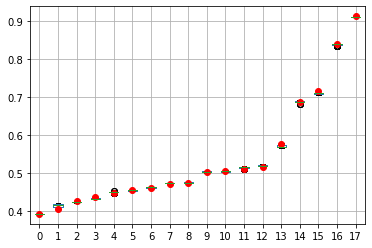

In [17]:
# produce a boxplot of our ensemble’s Democratic vote percentage vectors,
# with the initial 2011 districting plan plotted in red
ax = data.boxplot(positions=range(len(data.columns)))
plt.plot(data.iloc[0], "ro")

plt.show()

# 2: Running a chain with ReCom

This document shows how to run a chain using the ReCom proposal used in MGGG’s [2018 Virginia House of Delegates report](https://mggg.org/VA-report.pdf)

Use ReCom to generate an ensemble of districting plans for Pennsylvania, and then make a box plot comparing the Democratic vote shares for plans in our ensemble to the 2011 districting plan that the Pennsylvania Supreme Court found to be a Republican-favoring partisan gerrymander.

## Setting up the initial districting plan

In [2]:
graph = Graph.from_json("./PA_VTDs.json")

In [3]:
# configure Election objects representing some of 
# the election data from shapefile
elections = [
    Election(
        "SEN10", {"Democratic": "SEN10D", "Republican": "SEN10R"}
    ),
    Election(
        "SEN12", {"Democratic": "USS12D", "Republican": "USS12R"}
    ),
    Election(
        "SEN16", {"Democratic": "T16SEND", "Republican": "T16SENR"}
    ),
    Election(
        "PRES12", {"Democratic": "PRES12D", "Republican": "PRES12R"}
    ),
    Election(
        "PRES16", {"Democratic": "T16PRESD", "Republican": "T16PRESR"}
    )
]

#### Configuring our updaters

In [4]:
# Population updater, for computing how close to equality the district
# populations are. "TOTPOP" is the population column from our shapefile.
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population")}

# Election updaters, for computing election results using the vote totals
# from our shapefile.
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

#### Instantiating the partition

In [5]:
# instantiate the initial state of our Markov chain, 
# using the 2011 districting plan
initial_partition = GeographicPartition(graph, 
                                        assignment="CD_2011", 
                                        updaters=my_updaters)

## Setting up the Markov chain

#### Proposal

In [6]:
# The ReCom proposal needs to know the ideal population for the districts 
# we can improve speed by bailing early on unbalanced partitions.
ideal_population = \
    sum(initial_partition["population"].values()) / len(initial_partition)

# We use functools.partial to bind the extra parameters 
# (pop_col, pop_target, epsilon, node_repeats) of the recom proposal.
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )

#### Constraints

To keep districts about as compact as the original plan, we bound the number of cut edges at 2 times the number of cut edges in the initial plan

In [7]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = \
    constraints.within_percent_of_ideal_population(initial_partition, 0.02)

#### Configuring the Markov chain


In [8]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

#### Running the chain

Run the chain, putting the sorted Democratic vote percentages directly into a pandas DataFrame for analysis and plotting. The DataFrame will have a row for each state of the chain. The first column of the DataFrame will hold the lowest Democratic vote share among the districts in each partition in the chain, the second column will hold the second-lowest Democratic vote shares, and so on.

In [10]:
# This will take about 10 minutes.

data = pd.DataFrame(
    sorted(partition["SEN12"].percents("Democratic"))
    for partition in chain
)

#### Create a plot

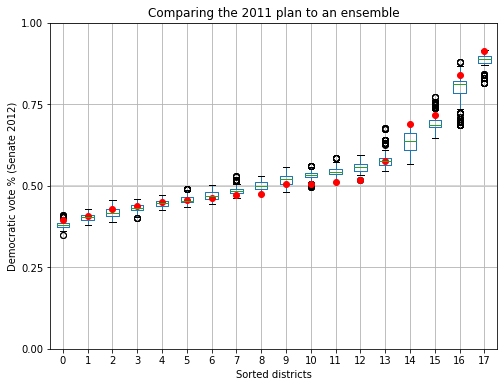

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
plt.plot(data.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2011 plan to an ensemble")
ax.set_ylabel("Democratic vote % (Senate 2012)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.show()

To build on this, here are some possible next steps:

* Add, remove, or tweak the constraints
* Use a different proposal from GerryChain, or create your own
* Perform a similar analysis on a different districting plan for Pennsylvania
* Perform a similar analysis on a different state
* Compute partisan symmetry scores like Efficiency Gap or Mean-Median, and create a histogram of the scores of the ensemble.
* Perform the same analysis using a different election than the 2012 Senate election
* Collect Democratic vote percentages for all the elections we set up, instead of just the 2012 Senate election.

# 3: Working with Partitions

A walk through the most common ways that you might work with a GerryChain Partition object

In [13]:
# use Pennsylvania VTD json to create the graph
graph = Graph.from_json("./PA_VTDs.json")

## Creating a partition

In [14]:
partition = Partition(graph, "CD_2011", {"cut_edges": cut_edges})

The Partition class takes three arguments to create a Partition:

* A graph.
* An assignment of nodes to districts. This can be the string name of a node attribute (shapefile column) that holds each node’s district assignment, or a dictionary mapping each node ID to its assigned district ID.
* A dictionary of updaters.

This creates a partition of the graph object we created above from the Pennsylvania shapefile. The partition is defined by the "CD_2011" column from our shapefile’s attribute table.

### `partition.graph`: the underlying graph

This contains no information about the partition—it will be the same graph object that you passed in to Partition() when you created the partition instance.

`partition.graph` is a gerrychain.Graph object. It is based on the NetworkX Graph object

In [15]:
partition.graph

<Graph [9255 nodes, 25723 edges]>

In [16]:
# shapefile’s attribute table attached to the graph as node attributes
partition.graph.nodes[0]

{'boundary_node': True,
 'boundary_perim': 0.06312599142331599,
 'area': 0.004278359631999892,
 'STATEFP10': '42',
 'COUNTYFP10': '085',
 'VTDST10': '960',
 'GEOID10': '42085960',
 'VTDI10': 'A',
 'NAME10': 'SHENANGO TWP VTD WEST',
 'NAMELSAD10': 'SHENANGO TWP VTD WEST',
 'LSAD10': '00',
 'MTFCC10': 'G5240',
 'FUNCSTAT10': 'N',
 'ALAND10': 39740056,
 'AWATER10': 141805,
 'INTPTLAT10': '+41.1564874',
 'INTPTLON10': '-080.4865792',
 'TOTPOP': 1915,
 'NH_WHITE': 1839,
 'NH_BLACK': 35,
 'NH_AMIN': 1,
 'NH_ASIAN': 8,
 'NH_NHPI': 0,
 'NH_OTHER': 3,
 'NH_2MORE': 19,
 'HISP': 10,
 'H_WHITE': 3,
 'H_BLACK': 0,
 'H_AMIN': 1,
 'H_ASIAN': 0,
 'H_NHPI': 0,
 'H_OTHER': 4,
 'H_2MORE': 2,
 'VAP': 1553,
 'HVAP': 7,
 'WVAP': 1494,
 'BVAP': 30,
 'AMINVAP': 1,
 'ASIANVAP': 6,
 'NHPIVAP': 0,
 'OTHERVAP': 2,
 '2MOREVAP': 13,
 'ATG12D': 514.0001036045286,
 'ATG12R': 388.0000782073095,
 'F2014GOVD': 290.0000584539169,
 'F2014GOVR': 242.00004877878584,
 'GOV10D': 289.00005825235166,
 'GOV10R': 349.000070346265

The nodes of the graph are identified by IDs. Here the IDs are the VTDs GEOIDs from the `"GEOID10"` column

### `partition.assignment`: assign nodes to parts

A mapping from `node IDs` to `part IDs` (“part” is our generic word for `“district”`). It is a custom data structure but you can use it just like a dictionary.

In [17]:
first_ten_nodes = list(partition.graph.nodes)[:10]
for node in first_ten_nodes:
    print(partition.assignment[node])

3
3
3
3
3
3
3
3
3
3


### `partition.parts`: the nodes in each part

A mapping from each `part ID` to `the set of nodes` that belong to that part

In [19]:
for part in sorted(partition.parts):
    number_of_nodes = len(partition.parts[part])
    print(f"Part {part} has {number_of_nodes} nodes")

Part 1 has 718 nodes
Part 2 has 828 nodes
Part 3 has 500 nodes
Part 4 has 292 nodes
Part 5 has 580 nodes
Part 6 has 313 nodes
Part 7 has 405 nodes
Part 8 has 340 nodes
Part 9 has 575 nodes
Part 10 has 515 nodes
Part 11 has 456 nodes
Part 12 has 623 nodes
Part 13 has 548 nodes
Part 14 has 867 nodes
Part 15 has 324 nodes
Part 16 has 329 nodes
Part 17 has 442 nodes
Part 18 has 600 nodes


### `partition.subgraphs`: the subgraphs of each part

For each part of our partition, we can look at the subgraph that it defines. That is, we can look at the graph made up of all the nodes in a certain part and all the edges between those nodes.

A mapping (like a dictionary) from part IDs to their subgraphs

In [23]:
for part, subgraph in sorted(partition.subgraphs.items(), 
                             key=lambda x: x[0]):
    number_of_edges = len(subgraph.edges)
    print(f"Part {part} has {number_of_edges} edges")

Part 1 has 1780 edges
Part 2 has 2159 edges
Part 3 has 1229 edges
Part 4 has 723 edges
Part 5 has 1450 edges
Part 6 has 749 edges
Part 7 has 931 edges
Part 8 has 886 edges
Part 9 has 1391 edges
Part 10 has 1252 edges
Part 11 has 1152 edges
Part 12 has 1601 edges
Part 13 has 1362 edges
Part 14 has 2344 edges
Part 15 has 834 edges
Part 16 has 836 edges
Part 17 has 1092 edges
Part 18 has 1585 edges


In [25]:
for part, subgraph in sorted(partition.subgraphs.items(), 
                             key=lambda x: x[0]):
    diameter = networkx.diameter(subgraph)
    print(f"Part {part} has diameter {diameter}")

Part 1 has diameter 50
Part 2 has diameter 28
Part 3 has diameter 40
Part 4 has diameter 19
Part 5 has diameter 30
Part 6 has diameter 32
Part 7 has diameter 38
Part 8 has diameter 24
Part 9 has diameter 40
Part 10 has diameter 40
Part 11 has diameter 31
Part 12 has diameter 36
Part 13 has diameter 30
Part 14 has diameter 38
Part 15 has diameter 28
Part 16 has diameter 38
Part 17 has diameter 34
Part 18 has diameter 28


## Outputs of updaters

The other main way we can extract information from partition is through the updaters that we configured when we created it.

In [27]:
len(partition["cut_edges"]), len(partition.cut_edges)

(2367, 2367)

In [29]:
proportion_of_cut_edges = \
    len(partition.cut_edges) / len(partition.graph.edges)
print("Proportion of edges that are cut:")
print(proportion_of_cut_edges)

Proportion of edges that are cut:
0.09201881584574116


# 4: Updaters

Depending on the questions you are investigating, there are many different values you might want to compute for each partition in your Markov chain. 
* If you are interested in compactness, you might want to compute the area and perimeter of each part of the partition so that you can compute compactness scores. 
* If you are interested in partisan lean, you might want to compute hypothetical election results using the districts defined by the partition.

The Partition class allows you to define custom properties for the partitions in your Markov chain. You can do this by providing a dictionary of updater functions when you first create a partition

In [30]:
graph = Graph()
graph.add_edges_from([(0,1), (1,2), (2,0)])
assignment = {0: 1, 1: 1, 2: 2}

def my_updater(partition):
    return "Hello!"

partition = Partition(graph, 
                      assignment, 
                      {"my_custom_property": my_updater})

partition["my_custom_property"], partition.my_custom_property

('Hello!', 'Hello!')

can access the value of this updater using either the “attribute-style” yntax `partition.my_custom_property` or the “dictionary-style” syntax `partition["my_custom_property"]`

This partition and all subsequent partitions in the chain will have this my_custom_property attribute. If we flip a node in partition to create a new partition, we can still access this property

In [31]:
new_partition = partition.flip({1: 2})
new_partition is not partition, new_partition["my_custom_property"]

(True, 'Hello!')

## Useful updater functions in GerryChain

The gerrychain.updaters submodule provides some updaters for common tasks like aggregating data and computing the cut edges of a partition:

* Tally: Aggregates a node attribute (e.g. population) over each part of the partition.
* cut_edges: Returns the set of cut edges (edges whose nodes are in different parts of the partition) of the partition. This is required for most of the proposal functions in gerrychain.proposals.

In [33]:
# We'll use a 2x2 grid graph:
graph = Graph()
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])

# Give each of the nodes population 100:
for node in graph:
    graph.nodes[node]["population"] = 100

# Partition the grid into two halves:
assignment = {0: 0, 1: 0, 2: 1, 3: 1}
partition = Partition(
    graph,
    assignment,
    updaters={"cut_edges": cut_edges, "population": Tally("population")}
)
partition["population"], partition["cut_edges"]

({0: 200, 1: 200}, {(0, 3), (1, 2)})

Our `cut_edges` updater returns a set of edges, each represented as a tuple of two nodes. Our `population` updater returns a dictionary mapping each part of the partition to the total population in that part. Since we divided our grid in half, we see parts `0` and `1` both have population 200.

Now when we create a new partition by flipping a node of partition, we see the values of the updaters change:

In [34]:
new_partition = partition.flip({0: 1})
new_partition["population"], new_partition["cut_edges"]

({0: 100, 1: 300}, {(0, 1), (1, 2)})

As we should expect, flipping node `0` into part `1` increases the population of `part 1` to `300` and decreases the population of `part 0` to `100`. The cut edges of the new partition are both of the edges incident to node `1`, since this is the last remaining node in part `0`.

## Writing your own updater function

When using GerryChain to experiment with new metrics, proposals, or acceptance rules, there usually comes a point when you need to implement a new updater.

In [35]:
# an updater that returns the number of cut edges in the partition
def number_of_cut_edges(partition):
    return len(partition["cut_edges"])

In [36]:
graph = Graph(networkx.complete_graph(4))
assignment = {0: 0, 1: 0, 2: 1, 3: 1}
my_updaters = {"cut_edges": cut_edges, 
               "number_of_cut_edges": number_of_cut_edges}
partition = Partition(graph, assignment, my_updaters)

In [37]:
partition["number_of_cut_edges"]

4

In [38]:
new_partition = partition.flip({0: 1})

In [39]:
new_partition["number_of_cut_edges"]

3